In [1]:
! pip install tqdm
! pip install ultralytics
! pip install gdown

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/e0/06/f07c56b8080af737ad42991fc1bb4e94da490c5227225c8337b8c248bd44/ultralytics-8.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 19.3 MB/s eta 0:00:00
  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/55/2e/abfb9226a0aaf7dd333f9475335a1d9522155307d69220d751c89fc0b85d/gdown-4.7.3-py3-none-any.whl.metadata


In [2]:
import argparse
from tqdm import tqdm
from ultralytics import YOLO
from collections import OrderedDict, deque
from enum import Enum
from scipy.optimize import linear_sum_assignment
import scipy
from __future__ import annotations
from dataclasses import astuple, dataclass, replace
from typing import Any, Dict, Iterator, List, Optional, Tuple, Union, Callable, Generator, Optional, Tuple, Set
import numpy as np
import cv2
from math import sqrt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DEFAULT_COLOR_PALETTE = ["#a351fb", "#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c","#fabebe","#008080","#e6beff","#aa6e28","#fffac8","#800000","#aaffc3"]
@dataclass
class Color:

    r: int
    g: int
    b: int

    @classmethod
    def from_hex(cls, color_hex: str) -> Color:
        color_hex = color_hex.lstrip("#")
        if len(color_hex) == 3:
            color_hex = "".join(c * 2 for c in color_hex)
        r, g, b = (int(color_hex[i : i + 2], 16) for i in range(0, 6, 2))
        return cls(r, g, b)

    def as_rgb(self) -> Tuple[int, int, int]:
        return self.r, self.g, self.b

    def as_bgr(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def white(cls) -> Color:
        return Color.from_hex(color_hex="#ffffff")

    @classmethod
    def black(cls) -> Color:
        return Color.from_hex(color_hex="#000000")

    @classmethod
    def red(cls) -> Color:
        return Color.from_hex(color_hex="#ff0000")

    @classmethod
    def green(cls) -> Color:
        return Color.from_hex(color_hex="#00ff00")

    @classmethod
    def blue(cls) -> Color:
        return Color.from_hex(color_hex="#0000ff")


@dataclass
class ColorPalette:
    colors: List[Color]

    @classmethod
    def default(cls) -> ColorPalette:
        return ColorPalette.from_hex(color_hex_list=DEFAULT_COLOR_PALETTE)

    @classmethod
    def from_hex(cls, color_hex_list: List[str]) -> ColorPalette:
        colors = [Color.from_hex(color_hex) for color_hex in color_hex_list]
        return cls(colors)

    def by_idx(self, idx: int) -> Color:
        if idx < 0:
            raise ValueError("idx argument should not be negative")
        idx = idx % len(self.colors)
        return self.colors[idx]

In [4]:
class Position(Enum):

    CENTER = "CENTER"
    CENTER_LEFT = "CENTER_LEFT"
    CENTER_RIGHT = "CENTER_RIGHT"
    TOP_CENTER = "TOP_CENTER"
    TOP_LEFT = "TOP_LEFT"
    TOP_RIGHT = "TOP_RIGHT"
    BOTTOM_LEFT = "BOTTOM_LEFT"
    BOTTOM_CENTER = "BOTTOM_CENTER"
    BOTTOM_RIGHT = "BOTTOM_RIGHT"
    CENTER_OF_MASS = "CENTER_OF_MASS"

    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

In [5]:
@dataclass
class Point:
    x: float
    y: float

    def as_xy_int_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)

    def as_xy_float_tuple(self) -> Tuple[float, float]:
        return self.x, self.y

In [6]:
@dataclass
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    def pad(self, padding) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2 * padding,
            height=self.height + 2 * padding,
        )

In [7]:
class ColorLookup(Enum):

    INDEX = "index"
    CLASS = "class"
    TRACK = "track"

    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

In [8]:
class Trace:
    def __init__(
        self,
        max_size: Optional[int] = None,
        start_frame_id: int = 0,
        anchor: Position = Position.CENTER,
    ) -> None:
        self.current_frame_id = start_frame_id
        self.max_size = max_size
        self.anchor = anchor

        self.frame_id = np.array([], dtype=int)
        self.xy = np.empty((0, 2), dtype=np.float32)
        self.tracker_id = np.array([], dtype=int)

    def put(self, detections: Detections) -> None:
        frame_id = np.full(len(detections), self.current_frame_id, dtype=int)
        self.frame_id = np.concatenate([self.frame_id, frame_id])
        self.xy = np.concatenate(
            [self.xy, detections.get_anchors_coordinates(self.anchor)]
        )
        self.tracker_id = np.concatenate([self.tracker_id, detections.tracker_id])

        unique_frame_id = np.unique(self.frame_id)

        if 0 < self.max_size < len(unique_frame_id):
            max_allowed_frame_id = self.current_frame_id - self.max_size + 1
            filtering_mask = self.frame_id >= max_allowed_frame_id
            self.frame_id = self.frame_id[filtering_mask]
            self.xy = self.xy[filtering_mask]
            self.tracker_id = self.tracker_id[filtering_mask]

        self.current_frame_id += 1

    def get(self, tracker_id: int) -> np.ndarray:
        return self.xy[self.tracker_id == tracker_id]

In [9]:
def get_color_by_index(color: Union[Color, ColorPalette], idx: int) -> Color:
    if isinstance(color, ColorPalette):
        return color.by_idx(idx)
    return color

In [10]:
def resolve_color_idx(
    detections: Detections,
    detection_idx: int,
    color_lookup: Union[ColorLookup, np.ndarray] = ColorLookup.CLASS,
) -> int:
    if detection_idx >= len(detections):
        raise ValueError(
            f"Detection index {detection_idx}"
            f"is out of bounds for detections of length {len(detections)}"
        )

    if isinstance(color_lookup, np.ndarray):
        if len(color_lookup) != len(detections):
            raise ValueError(
                f"Length of color lookup {len(color_lookup)}"
                f"does not match length of detections {len(detections)}"
            )
        return color_lookup[detection_idx]
    elif color_lookup == ColorLookup.INDEX:
        return detection_idx
    elif color_lookup == ColorLookup.CLASS:
        if detections.class_id is None:
            raise ValueError(
                "Could not resolve color by class because"
                "Detections do not have class_id"
            )
        return detections.class_id[detection_idx]
    elif color_lookup == ColorLookup.TRACK:
        if detections.tracker_id is None:
            raise ValueError(
                "Could not resolve color by track because"
                "Detections do not have tracker_id"
            )
        return detections.tracker_id[detection_idx]

In [11]:
def resolve_color(
    color: Union[Color, ColorPalette],
    detections: Detections,
    detection_idx: int,
    color_lookup: Union[ColorLookup, np.ndarray] = ColorLookup.CLASS,
) -> Color:
    idx = resolve_color_idx(
        detections=detections,
        detection_idx=detection_idx,
        color_lookup=color_lookup,
    )
    return get_color_by_index(color=color, idx=idx)

In [12]:
def calculate_masks_centroids(masks: np.ndarray) -> np.ndarray:
    num_masks, height, width = masks.shape
    total_pixels = masks.sum(axis=(1, 2))

    # offset for 1-based indexing
    vertical_indices, horizontal_indices = np.indices((height, width)) + 0.5
    # avoid division by zero for empty masks
    total_pixels[total_pixels == 0] = 1

    def sum_over_mask(indices: np.ndarray, axis: tuple) -> np.ndarray:
        return np.tensordot(masks, indices, axes=axis)

    aggregation_axis = ([1, 2], [0, 1])
    centroid_x = sum_over_mask(horizontal_indices, aggregation_axis) / total_pixels
    centroid_y = sum_over_mask(vertical_indices, aggregation_axis) / total_pixels

    return np.column_stack((centroid_x, centroid_y)).astype(int)

In [13]:
def extract_ultralytics_masks(yolov8_results) -> Optional[np.ndarray]:
    if not yolov8_results.masks:
        return None

    orig_shape = yolov8_results.orig_shape
    inference_shape = tuple(yolov8_results.masks.data.shape[1:])

    gain = 0
    pad = (0, 0)

    if inference_shape != orig_shape:
        gain = min(
            inference_shape[0] / orig_shape[0],
            inference_shape[1] / orig_shape[1],
        )
        pad = (
            (inference_shape[1] - orig_shape[1] * gain) / 2,
            (inference_shape[0] - orig_shape[0] * gain) / 2,
        )

    top, left = int(pad[1]), int(pad[0])
    bottom, right = int(inference_shape[0] - pad[1]), int(inference_shape[1] - pad[0])

    mask_maps = []
    masks = yolov8_results.masks.data.cpu().numpy()
    for i in range(masks.shape[0]):
        mask = masks[i]
        mask = mask[top:bottom, left:right]

        if mask.shape != orig_shape:
            mask = cv2.resize(mask, (orig_shape[1], orig_shape[0]))

        mask_maps.append(mask)

    return np.asarray(mask_maps, dtype=bool)

In [14]:
def non_max_suppression(
    predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    assert 0 <= iou_threshold <= 1, (
        "Value of `iou_threshold` must be in the closed range from 0 to 1, "
        f"{iou_threshold} given."
    )
    rows, columns = predictions.shape

    # add column #5 - category filled with zeros for agnostic nms
    if columns == 5:
        predictions = np.c_[predictions, np.zeros(rows)]

    # sort predictions column #4 - score
    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        # drop detections with iou > iou_threshold and
        # same category as current detections
        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

In [15]:
def clip_boxes(xyxy: np.ndarray, resolution_wh: Tuple[int, int]) -> np.ndarray:
    result = np.copy(xyxy)
    width, height = resolution_wh
    result[:, [0, 2]] = result[:, [0, 2]].clip(0, width)
    result[:, [1, 3]] = result[:, [1, 3]].clip(0, height)
    return result

In [16]:
def _validate_xyxy(xyxy: Any, n: int) -> None:
    is_valid = isinstance(xyxy, np.ndarray) and xyxy.shape == (n, 4)
    if not is_valid:
        raise ValueError("xyxy must be 2d np.ndarray with (n, 4) shape")


def _validate_mask(mask: Any, n: int) -> None:
    is_valid = mask is None or (
        isinstance(mask, np.ndarray) and len(mask.shape) == 3 and mask.shape[0] == n
    )
    if not is_valid:
        raise ValueError("mask must be 3d np.ndarray with (n, H, W) shape")


def validate_inference_callback(callback) -> None:
    tmp_img = np.zeros((256, 256, 3), dtype=np.uint8)
    res = callback(tmp_img)
    if not isinstance(res, Detections):
        raise ValueError("Callback function must return sv.Detection type")


def _validate_class_id(class_id: Any, n: int) -> None:
    is_valid = class_id is None or (
        isinstance(class_id, np.ndarray) and class_id.shape == (n,)
    )
    if not is_valid:
        raise ValueError("class_id must be None or 1d np.ndarray with (n,) shape")


def _validate_confidence(confidence: Any, n: int) -> None:
    is_valid = confidence is None or (
        isinstance(confidence, np.ndarray) and confidence.shape == (n,)
    )
    if not is_valid:
        raise ValueError("confidence must be None or 1d np.ndarray with (n,) shape")


def _validate_tracker_id(tracker_id: Any, n: int) -> None:
    is_valid = tracker_id is None or (
        isinstance(tracker_id, np.ndarray) and tracker_id.shape == (n,)
    )
    if not is_valid:
        raise ValueError("tracker_id must be None or 1d np.ndarray with (n,) shape")


@dataclass
class Detections:

    xyxy: np.ndarray
    mask: Optional[np.ndarray] = None
    confidence: Optional[np.ndarray] = None
    class_id: Optional[np.ndarray] = None
    tracker_id: Optional[np.ndarray] = None

    def __post_init__(self):
        n = len(self.xyxy)
        _validate_xyxy(xyxy=self.xyxy, n=n)
        _validate_mask(mask=self.mask, n=n)
        _validate_class_id(class_id=self.class_id, n=n)
        _validate_confidence(confidence=self.confidence, n=n)
        _validate_tracker_id(tracker_id=self.tracker_id, n=n)

    def __len__(self):
        return len(self.xyxy)

    def __iter__(
        self,
    ) -> Iterator[
        Tuple[
            np.ndarray,
            Optional[np.ndarray],
            Optional[float],
            Optional[int],
            Optional[int],
        ]
    ]:
        """
        Iterates over the Detections object and yield a tuple of
        `(xyxy, mask, confidence, class_id, tracker_id)` for each detection.
        """
        for i in range(len(self.xyxy)):
            yield (
                self.xyxy[i],
                self.mask[i] if self.mask is not None else None,
                self.confidence[i] if self.confidence is not None else None,
                self.class_id[i] if self.class_id is not None else None,
                self.tracker_id[i] if self.tracker_id is not None else None,
            )

    def __eq__(self, other: Detections):
        return all(
            [
                np.array_equal(self.xyxy, other.xyxy),
                any(
                    [
                        self.mask is None and other.mask is None,
                        np.array_equal(self.mask, other.mask),
                    ]
                ),
                any(
                    [
                        self.class_id is None and other.class_id is None,
                        np.array_equal(self.class_id, other.class_id),
                    ]
                ),
                any(
                    [
                        self.confidence is None and other.confidence is None,
                        np.array_equal(self.confidence, other.confidence),
                    ]
                ),
                any(
                    [
                        self.tracker_id is None and other.tracker_id is None,
                        np.array_equal(self.tracker_id, other.tracker_id),
                    ]
                ),
            ]
        )

    @classmethod
    def from_ultralytics(cls, ultralytics_results) -> Detections:

        return cls(
            xyxy=ultralytics_results.boxes.xyxy.cpu().numpy(),
            confidence=ultralytics_results.boxes.conf.cpu().numpy(),
            class_id=ultralytics_results.boxes.cls.cpu().numpy().astype(int),
            mask=extract_ultralytics_masks(ultralytics_results),
            tracker_id=ultralytics_results.boxes.id.int().cpu().numpy()
            if ultralytics_results.boxes.id is not None
            else None,
        )



    @classmethod
    def empty(cls) -> Detections:
        return cls(
            xyxy=np.empty((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=int),
        )

    def get_anchors_coordinates(self, anchor: Position) -> np.ndarray:
        if anchor == Position.CENTER:
            return np.array(
                [
                    (self.xyxy[:, 0] + self.xyxy[:, 2]) / 2,
                    (self.xyxy[:, 1] + self.xyxy[:, 3]) / 2,
                ]
            ).transpose()
        elif anchor == Position.CENTER_OF_MASS:
            if self.mask is None:
                raise ValueError(
                    "Cannot use `Position.CENTER_OF_MASS` without a detection mask."
                )
            return calculate_masks_centroids(masks=self.mask)
        elif anchor == Position.CENTER_LEFT:
            return np.array(
                [
                    self.xyxy[:, 0],
                    (self.xyxy[:, 1] + self.xyxy[:, 3]) / 2,
                ]
            ).transpose()
        elif anchor == Position.CENTER_RIGHT:
            return np.array(
                [
                    self.xyxy[:, 2],
                    (self.xyxy[:, 1] + self.xyxy[:, 3]) / 2,
                ]
            ).transpose()
        elif anchor == Position.BOTTOM_CENTER:
            return np.array(
                [(self.xyxy[:, 0] + self.xyxy[:, 2]) / 2, self.xyxy[:, 3]]
            ).transpose()
        elif anchor == Position.BOTTOM_LEFT:
            return np.array([self.xyxy[:, 0], self.xyxy[:, 3]]).transpose()
        elif anchor == Position.BOTTOM_RIGHT:
            return np.array([self.xyxy[:, 2], self.xyxy[:, 3]]).transpose()
        elif anchor == Position.TOP_CENTER:
            return np.array(
                [(self.xyxy[:, 0] + self.xyxy[:, 2]) / 2, self.xyxy[:, 1]]
            ).transpose()
        elif anchor == Position.TOP_LEFT:
            return np.array([self.xyxy[:, 0], self.xyxy[:, 1]]).transpose()
        elif anchor == Position.TOP_RIGHT:
            return np.array([self.xyxy[:, 2], self.xyxy[:, 1]]).transpose()

        raise ValueError(f"{anchor} is not supported.")

    def __getitem__(
        self, index: Union[int, slice, List[int], np.ndarray]
    ) -> Detections:
        if isinstance(index, int):
            index = [index]
        return Detections(
            xyxy=self.xyxy[index],
            mask=self.mask[index] if self.mask is not None else None,
            confidence=self.confidence[index] if self.confidence is not None else None,
            class_id=self.class_id[index] if self.class_id is not None else None,
            tracker_id=self.tracker_id[index] if self.tracker_id is not None else None,
        )

    @property
    def area(self) -> np.ndarray:
        if self.mask is not None:
            return np.array([np.sum(mask) for mask in self.mask])
        else:
            return self.box_area

    @property
    def box_area(self) -> np.ndarray:
        return (self.xyxy[:, 3] - self.xyxy[:, 1]) * (self.xyxy[:, 2] - self.xyxy[:, 0])

In [17]:
class TrackState(Enum):
    New = 0
    Tracked = 1
    Lost = 2
    Removed = 3


class BaseTrack:
    _count = 0

    def __init__(self):
        self.track_id = 0
        self.is_activated = False
        self.state = TrackState.New

        self.history = OrderedDict()
        self.features = []
        self.curr_feature = None
        self.score = 0
        self.start_frame = 0
        self.frame_id = 0
        self.time_since_update = 0

        # multi-camera
        self.location = (np.inf, np.inf)

    @property
    def end_frame(self) -> int:
        return self.frame_id

    @staticmethod
    def next_id() -> int:
        BaseTrack._count += 1
        return BaseTrack._count

    def activate(self, *args):
        raise NotImplementedError

    def predict(self):
        raise NotImplementedError

    def update(self, *args, **kwargs):
        raise NotImplementedError

    def mark_lost(self):
        self.state = TrackState.Lost

    def mark_removed(self):
        self.state = TrackState.Removed

In [18]:
class KalmanFilter:

    def __init__(self):
        ndim, dt = 4, 1.0

        self._motion_mat = np.eye(2 * ndim, 2 * ndim)
        for i in range(ndim):
            self._motion_mat[i, ndim + i] = dt
        self._update_mat = np.eye(ndim, 2 * ndim)
        self._std_weight_position = 1.0 / 20
        self._std_weight_velocity = 1.0 / 160

    def initiate(self, measurement: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        mean_pos = measurement
        mean_vel = np.zeros_like(mean_pos)
        mean = np.r_[mean_pos, mean_vel]

        std = [
            2 * self._std_weight_position * measurement[3],
            2 * self._std_weight_position * measurement[3],
            1e-2,
            2 * self._std_weight_position * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            1e-5,
            10 * self._std_weight_velocity * measurement[3],
        ]
        covariance = np.diag(np.square(std))
        return mean, covariance

    def predict(
        self, mean: np.ndarray, covariance: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        std_pos = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-2,
            self._std_weight_position * mean[3],
        ]
        std_vel = [
            self._std_weight_velocity * mean[3],
            self._std_weight_velocity * mean[3],
            1e-5,
            self._std_weight_velocity * mean[3],
        ]
        motion_cov = np.diag(np.square(np.r_[std_pos, std_vel]))

        mean = np.dot(mean, self._motion_mat.T)
        covariance = (
            np.linalg.multi_dot((self._motion_mat, covariance, self._motion_mat.T))
            + motion_cov
        )

        return mean, covariance

    def project(
        self, mean: np.ndarray, covariance: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        std = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-1,
            self._std_weight_position * mean[3],
        ]
        innovation_cov = np.diag(np.square(std))

        mean = np.dot(self._update_mat, mean)
        covariance = np.linalg.multi_dot(
            (self._update_mat, covariance, self._update_mat.T)
        )
        return mean, covariance + innovation_cov

    def multi_predict(
        self, mean: np.ndarray, covariance: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        std_pos = [
            self._std_weight_position * mean[:, 3],
            self._std_weight_position * mean[:, 3],
            1e-2 * np.ones_like(mean[:, 3]),
            self._std_weight_position * mean[:, 3],
        ]
        std_vel = [
            self._std_weight_velocity * mean[:, 3],
            self._std_weight_velocity * mean[:, 3],
            1e-5 * np.ones_like(mean[:, 3]),
            self._std_weight_velocity * mean[:, 3],
        ]
        sqr = np.square(np.r_[std_pos, std_vel]).T

        motion_cov = []
        for i in range(len(mean)):
            motion_cov.append(np.diag(sqr[i]))
        motion_cov = np.asarray(motion_cov)

        mean = np.dot(mean, self._motion_mat.T)
        left = np.dot(self._motion_mat, covariance).transpose((1, 0, 2))
        covariance = np.dot(left, self._motion_mat.T) + motion_cov

        return mean, covariance

    def update(
        self, mean: np.ndarray, covariance: np.ndarray, measurement: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        projected_mean, projected_cov = self.project(mean, covariance)

        chol_factor, lower = scipy.linalg.cho_factor(
            projected_cov, lower=True, check_finite=False
        )
        kalman_gain = scipy.linalg.cho_solve(
            (chol_factor, lower),
            np.dot(covariance, self._update_mat.T).T,
            check_finite=False,
        ).T
        innovation = measurement - projected_mean

        new_mean = mean + np.dot(innovation, kalman_gain.T)
        new_covariance = covariance - np.linalg.multi_dot(
            (kalman_gain, projected_cov, kalman_gain.T)
        )
        return new_mean, new_covariance

In [19]:
class STrack(BaseTrack):
    shared_kalman = KalmanFilter()

    def __init__(self, tlwh, score, class_ids):
        # wait activate
        self._tlwh = np.asarray(tlwh, dtype=np.float32)
        self.kalman_filter = None
        self.mean, self.covariance = None, None
        self.is_activated = False

        self.score = score
        self.class_ids = class_ids
        self.tracklet_len = 0

    def predict(self):
        mean_state = self.mean.copy()
        if self.state != TrackState.Tracked:
            mean_state[7] = 0
        self.mean, self.covariance = self.kalman_filter.predict(
            mean_state, self.covariance
        )

    @staticmethod
    def multi_predict(stracks):
        if len(stracks) > 0:
            multi_mean = []
            multi_covariance = []
            for i, st in enumerate(stracks):
                multi_mean.append(st.mean.copy())
                multi_covariance.append(st.covariance)
                if st.state != TrackState.Tracked:
                    multi_mean[i][7] = 0

            multi_mean, multi_covariance = STrack.shared_kalman.multi_predict(
                np.asarray(multi_mean), np.asarray(multi_covariance)
            )
            for i, (mean, cov) in enumerate(zip(multi_mean, multi_covariance)):
                stracks[i].mean = mean
                stracks[i].covariance = cov

    def activate(self, kalman_filter, frame_id):
        """Start a new tracklet"""
        self.kalman_filter = kalman_filter
        self.track_id = self.next_id()
        self.mean, self.covariance = self.kalman_filter.initiate(
            self.tlwh_to_xyah(self._tlwh)
        )

        self.tracklet_len = 0
        self.state = TrackState.Tracked
        if frame_id == 1:
            self.is_activated = True
        self.frame_id = frame_id
        self.start_frame = frame_id

    def re_activate(self, new_track, frame_id, new_id=False):
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_track.tlwh)
        )
        self.tracklet_len = 0
        self.state = TrackState.Tracked
        self.is_activated = True
        self.frame_id = frame_id
        if new_id:
            self.track_id = self.next_id()
        self.score = new_track.score

    def update(self, new_track, frame_id):
        self.frame_id = frame_id
        self.tracklet_len += 1

        new_tlwh = new_track.tlwh
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_tlwh)
        )
        self.state = TrackState.Tracked
        self.is_activated = True

        self.score = new_track.score

    @property
    def tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
        width, height)`.
        """
        if self.mean is None:
            return self._tlwh.copy()
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    @property
    def tlbr(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    @staticmethod
    def tlwh_to_xyah(tlwh):
        """Convert bounding box to format `(center x, center y, aspect ratio,
        height)`, where the aspect ratio is `width / height`.
        """
        ret = np.asarray(tlwh).copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

    def to_xyah(self):
        return self.tlwh_to_xyah(self.tlwh)

    @staticmethod
    def tlbr_to_tlwh(tlbr):
        ret = np.asarray(tlbr).copy()
        ret[2:] -= ret[:2]
        return ret

    @staticmethod
    def tlwh_to_tlbr(tlwh):
        ret = np.asarray(tlwh).copy()
        ret[2:] += ret[:2]
        return ret

    def __repr__(self):
        return "OT_{}_({}-{})".format(self.track_id, self.start_frame, self.end_frame)

In [20]:
def box_iou_batch(boxes_true: np.ndarray, boxes_detection: np.ndarray) -> np.ndarray:

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_true = box_area(boxes_true.T)
    area_detection = box_area(boxes_detection.T)

    top_left = np.maximum(boxes_true[:, None, :2], boxes_detection[:, :2])
    bottom_right = np.minimum(boxes_true[:, None, 2:], boxes_detection[:, 2:])

    area_inter = np.prod(np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
    return area_inter / (area_true[:, None] + area_detection - area_inter)

In [21]:
def indices_to_matches(
    cost_matrix: np.ndarray, indices: np.ndarray, thresh: float
) -> Tuple[np.ndarray, tuple, tuple]:
    matched_cost = cost_matrix[tuple(zip(*indices))]
    matched_mask = matched_cost <= thresh

    matches = indices[matched_mask]
    unmatched_a = tuple(set(range(cost_matrix.shape[0])) - set(matches[:, 0]))
    unmatched_b = tuple(set(range(cost_matrix.shape[1])) - set(matches[:, 1]))
    return matches, unmatched_a, unmatched_b


def linear_assignment(
    cost_matrix: np.ndarray, thresh: float
) -> [np.ndarray, Tuple[int], Tuple[int, int]]:
    if cost_matrix.size == 0:
        return (
            np.empty((0, 2), dtype=int),
            tuple(range(cost_matrix.shape[0])),
            tuple(range(cost_matrix.shape[1])),
        )

    cost_matrix[cost_matrix > thresh] = thresh + 1e-4
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    indices = np.column_stack((row_ind, col_ind))

    return indices_to_matches(cost_matrix, indices, thresh)


def iou_distance(atracks: List, btracks: List) -> np.ndarray:
    if (len(atracks) > 0 and isinstance(atracks[0], np.ndarray)) or (
        len(btracks) > 0 and isinstance(btracks[0], np.ndarray)
    ):
        atlbrs = atracks
        btlbrs = btracks
    else:
        atlbrs = [track.tlbr for track in atracks]
        btlbrs = [track.tlbr for track in btracks]

    _ious = np.zeros((len(atlbrs), len(btlbrs)), dtype=np.float32)
    if _ious.size != 0:
        _ious = box_iou_batch(np.asarray(atlbrs), np.asarray(btlbrs))
    cost_matrix = 1 - _ious

    return cost_matrix


def fuse_score(cost_matrix: np.ndarray, detections: List) -> np.ndarray:
    if cost_matrix.size == 0:
        return cost_matrix
    iou_sim = 1 - cost_matrix
    det_scores = np.array([det.score for det in detections])
    det_scores = np.expand_dims(det_scores, axis=0).repeat(cost_matrix.shape[0], axis=0)
    fuse_sim = iou_sim * det_scores
    fuse_cost = 1 - fuse_sim
    return fuse_cost

In [22]:
class ByteTrack:

    def __init__(
        self,
        track_thresh: float = 0.25,
        track_buffer: int = 30,
        match_thresh: float = 0.8,
        frame_rate: int = 30,
    ):
        self.track_thresh = track_thresh
        self.match_thresh = match_thresh

        self.frame_id = 0
        self.det_thresh = self.track_thresh + 0.1
        self.max_time_lost = int(frame_rate / 30.0 * track_buffer)
        self.kalman_filter = KalmanFilter()

        self.tracked_tracks: List[STrack] = []
        self.lost_tracks: List[STrack] = []
        self.removed_tracks: List[STrack] = []

    def update_with_detections(self, detections: Detections) -> Detections:

        tracks = self.update_with_tensors(
            tensors=detections2boxes(detections=detections)
        )
        detections = Detections.empty()
        if len(tracks) > 0:
            detections.xyxy = np.array(
                [track.tlbr for track in tracks], dtype=np.float32
            )
            detections.class_id = np.array(
                [int(t.class_ids) for t in tracks], dtype=int
            )
            detections.tracker_id = np.array(
                [int(t.track_id) for t in tracks], dtype=int
            )
            detections.confidence = np.array(
                [t.score for t in tracks], dtype=np.float32
            )
        else:
            detections.tracker_id = np.array([], dtype=int)

        return detections

    def update_with_tensors(self, tensors: np.ndarray) -> List[STrack]:

        self.frame_id += 1
        activated_starcks = []
        refind_stracks = []
        lost_stracks = []
        removed_stracks = []

        class_ids = tensors[:, 5]
        scores = tensors[:, 4]
        bboxes = tensors[:, :4]

        remain_inds = scores > self.track_thresh
        inds_low = scores > 0.1
        inds_high = scores < self.track_thresh

        inds_second = np.logical_and(inds_low, inds_high)
        dets_second = bboxes[inds_second]
        dets = bboxes[remain_inds]
        scores_keep = scores[remain_inds]
        scores_second = scores[inds_second]

        class_ids_keep = class_ids[remain_inds]
        class_ids_second = class_ids[inds_second]

        if len(dets) > 0:
            """Detections"""
            detections = [
                STrack(STrack.tlbr_to_tlwh(tlbr), s, c)
                for (tlbr, s, c) in zip(dets, scores_keep, class_ids_keep)
            ]
        else:
            detections = []

        """ Add newly detected tracklets to tracked_stracks"""
        unconfirmed = []
        tracked_stracks = []  # type: list[STrack]
        for track in self.tracked_tracks:
            if not track.is_activated:
                unconfirmed.append(track)
            else:
                tracked_stracks.append(track)

        """ Step 2: First association, with high score detection boxes"""
        strack_pool = joint_tracks(tracked_stracks, self.lost_tracks)
        # Predict the current location with KF
        STrack.multi_predict(strack_pool)
        dists = iou_distance(strack_pool, detections)

        dists = fuse_score(dists, detections)
        matches, u_track, u_detection = linear_assignment(
            dists, thresh=self.match_thresh
        )

        for itracked, idet in matches:
            track = strack_pool[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(detections[idet], self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        """ Step 3: Second association, with low score detection boxes"""
        # association the untrack to the low score detections
        if len(dets_second) > 0:
            """Detections"""
            detections_second = [
                STrack(STrack.tlbr_to_tlwh(tlbr), s, c)
                for (tlbr, s, c) in zip(dets_second, scores_second, class_ids_second)
            ]
        else:
            detections_second = []
        r_tracked_stracks = [
            strack_pool[i]
            for i in u_track
            if strack_pool[i].state == TrackState.Tracked
        ]
        dists = iou_distance(r_tracked_stracks, detections_second)
        matches, u_track, u_detection_second = linear_assignment(
            dists, thresh=0.5
        )
        for itracked, idet in matches:
            track = r_tracked_stracks[itracked]
            det = detections_second[idet]
            if track.state == TrackState.Tracked:
                track.update(det, self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        for it in u_track:
            track = r_tracked_stracks[it]
            if not track.state == TrackState.Lost:
                track.mark_lost()
                lost_stracks.append(track)

        """Deal with unconfirmed tracks, usually tracks with only one beginning frame"""
        detections = [detections[i] for i in u_detection]
        dists = iou_distance(unconfirmed, detections)

        dists = fuse_score(dists, detections)
        matches, u_unconfirmed, u_detection = linear_assignment(
            dists, thresh=0.7
        )
        for itracked, idet in matches:
            unconfirmed[itracked].update(detections[idet], self.frame_id)
            activated_starcks.append(unconfirmed[itracked])
        for it in u_unconfirmed:
            track = unconfirmed[it]
            track.mark_removed()
            removed_stracks.append(track)

        """ Step 4: Init new stracks"""
        for inew in u_detection:
            track = detections[inew]
            if track.score < self.det_thresh:
                continue
            track.activate(self.kalman_filter, self.frame_id)
            activated_starcks.append(track)
        """ Step 5: Update state"""
        for track in self.lost_tracks:
            if self.frame_id - track.end_frame > self.max_time_lost:
                track.mark_removed()
                removed_stracks.append(track)

        self.tracked_tracks = [
            t for t in self.tracked_tracks if t.state == TrackState.Tracked
        ]
        self.tracked_tracks = joint_tracks(self.tracked_tracks, activated_starcks)
        self.tracked_tracks = joint_tracks(self.tracked_tracks, refind_stracks)
        self.lost_tracks = sub_tracks(self.lost_tracks, self.tracked_tracks)
        self.lost_tracks.extend(lost_stracks)
        self.lost_tracks = sub_tracks(self.lost_tracks, self.removed_tracks)
        self.removed_tracks.extend(removed_stracks)
        self.tracked_tracks, self.lost_tracks = remove_duplicate_tracks(
            self.tracked_tracks, self.lost_tracks
        )
        output_stracks = [track for track in self.tracked_tracks if track.is_activated]

        return output_stracks


def joint_tracks(
    track_list_a: List[STrack], track_list_b: List[STrack]
) -> List[STrack]:
    seen_track_ids = set()
    result = []

    for track in track_list_a + track_list_b:
        if track.track_id not in seen_track_ids:
            seen_track_ids.add(track.track_id)
            result.append(track)

    return result


def sub_tracks(track_list_a: List, track_list_b: List) -> List[int]:
    tracks = {track.track_id: track for track in track_list_a}
    track_ids_b = {track.track_id for track in track_list_b}

    for track_id in track_ids_b:
        tracks.pop(track_id, None)

    return list(tracks.values())


def remove_duplicate_tracks(tracks_a: List, tracks_b: List) -> Tuple[List, List]:
    pairwise_distance = iou_distance(tracks_a, tracks_b)
    matching_pairs = np.where(pairwise_distance < 0.15)

    duplicates_a, duplicates_b = set(), set()
    for track_index_a, track_index_b in zip(*matching_pairs):
        time_a = tracks_a[track_index_a].frame_id - tracks_a[track_index_a].start_frame
        time_b = tracks_b[track_index_b].frame_id - tracks_b[track_index_b].start_frame
        if time_a > time_b:
            duplicates_b.add(track_index_b)
        else:
            duplicates_a.add(track_index_a)

    result_a = [
        track for index, track in enumerate(tracks_a) if index not in duplicates_a
    ]
    result_b = [
        track for index, track in enumerate(tracks_b) if index not in duplicates_b
    ]

    return result_a, result_b

def detections2boxes(detections: Detections) -> np.ndarray:
    
    return np.hstack(
        (
            detections.xyxy,
            detections.confidence[:, np.newaxis],
            detections.class_id[:, np.newaxis],
        )
    )

In [23]:
@dataclass
class VideoInfo:

    width: int
    height: int
    fps: int
    total_frames: Optional[int] = None

    @classmethod
    def from_video_path(cls, video_path: str) -> VideoInfo:
        video = cv2.VideoCapture(video_path)
        if not video.isOpened():
            raise Exception(f"Could not open video at {video_path}")

        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        video.release()
        return VideoInfo(width, height, fps, total_frames)

    @property
    def resolution_wh(self) -> Tuple[int, int]:
        return self.width, self.height


class VideoSink:

    def __init__(self, target_path: str, video_info: VideoInfo, codec: str = "mp4v"):
        self.target_path = target_path
        self.video_info = video_info
        self.__codec = codec
        self.__writer = None

    def __enter__(self):
        try:
            self.__fourcc = cv2.VideoWriter_fourcc(*self.__codec)
        except TypeError as e:
            print(str(e) + ". Defaulting to mp4v...")
            self.__fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        self.__writer = cv2.VideoWriter(
            self.target_path,
            self.__fourcc,
            self.video_info.fps,
            self.video_info.resolution_wh,
        )
        return self

    def write_frame(self, frame: np.ndarray):
        self.__writer.write(frame)

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.__writer.release()


def _validate_and_setup_video(source_path: str, start: int, end: Optional[int]):
    video = cv2.VideoCapture(source_path)
    if not video.isOpened():
        raise Exception(f"Could not open video at {source_path}")
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if end is not None and end > total_frames:
        raise Exception("Requested frames are outbound")
    start = max(start, 0)
    end = min(end, total_frames) if end is not None else total_frames
    video.set(cv2.CAP_PROP_POS_FRAMES, start)
    return video, start, end


def get_video_frames_generator(
    source_path: str, stride: int = 1, start: int = 0, end: Optional[int] = None
) -> Generator[np.ndarray, None, None]:
    
    video, start, end = _validate_and_setup_video(source_path, start, end)
    frame_position = start
    while True:
        success, frame = video.read()
        if not success or frame_position >= end:
            break
        yield frame
        for _ in range(stride - 1):
            success = video.grab()
            if not success:
                break
        frame_position += stride
    video.release()


def process_video(
    source_path: str,
    target_path: str,
    callback: Callable[[np.ndarray, int], np.ndarray],
) -> None:
    
    source_video_info = VideoInfo.from_video_path(video_path=source_path)
    with VideoSink(target_path=target_path, video_info=source_video_info) as sink:
        for index, frame in enumerate(
            get_video_frames_generator(source_path=source_path)
        ):
            result_frame = callback(frame, index)
            sink.write_frame(frame=result_frame)

In [24]:
class BoxAnnotator:

    def __init__(
        self,
        color: Union[Color, ColorPalette],
        thickness: int = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
    ):
        self.color: Union[Color, ColorPalette] = color
        self.thickness: int = thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_thickness: int = text_thickness
        self.text_padding: int = text_padding

    def annotate(
        self,
        scene: np.ndarray,
        detections: Detections,
        labels: Optional[List[str]] = None,
        skip_label: bool = False,
    ) -> np.ndarray:
        font = cv2.FONT_HERSHEY_SIMPLEX
        for i in range(len(detections)):
            x1, y1, x2, y2 = detections.xyxy[i].astype(int)
            class_id = (
                detections.class_id[i] if detections.class_id is not None else None
            )
            idx = class_id if class_id is not None else i
            color = (
                self.color.by_idx(idx)
                if isinstance(self.color, ColorPalette)
                else self.color
            )
            cv2.rectangle(
                img=scene,
                pt1=(x1, y1),
                pt2=(x2, y2),
                color=color.as_bgr(),
                thickness=self.thickness,
            )
            if skip_label:
                continue

            text = (
                f"{class_id}"
                if (labels is None or len(detections) != len(labels))
                else labels[i]
            )

            text_width, text_height = cv2.getTextSize(
                text=text,
                fontFace=font,
                fontScale=self.text_scale,
                thickness=self.text_thickness,
            )[0]

            text_x = x1 + self.text_padding
            text_y = y1 - self.text_padding

            text_background_x1 = x1
            text_background_y1 = y1 - 2 * self.text_padding - text_height

            text_background_x2 = x1 + 2 * self.text_padding + text_width
            text_background_y2 = y1

            cv2.rectangle(
                img=scene,
                pt1=(text_background_x1, text_background_y1),
                pt2=(text_background_x2, text_background_y2),
                color=color.as_bgr(),
                thickness=cv2.FILLED,
            )
            cv2.putText(
                img=scene,
                text=text,
                org=(text_x, text_y),
                fontFace=font,
                fontScale=self.text_scale,
                color=self.text_color.as_rgb(),
                thickness=self.text_thickness,
                lineType=cv2.LINE_AA,
            )
        return scene

In [25]:
class TraceAnnotator:

    def __init__(
        self,
        color: Union[Color, ColorPalette] = ColorPalette.default(),
        position: Position = Position.CENTER,
        trace_length: int = 30,
        thickness: int = 2,
        color_lookup: ColorLookup = ColorLookup.CLASS,
    ):
        self.color: Union[Color, ColorPalette] = color
        self.trace = Trace(max_size=trace_length, anchor=position)
        self.thickness = thickness
        self.color_lookup: ColorLookup = color_lookup

    def annotate(
        self,
        scene: np.ndarray,
        detections: Detections,
        custom_color_lookup: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        self.trace.put(detections)

        for detection_idx in range(len(detections)):
            tracker_id = int(detections.tracker_id[detection_idx])
            color = resolve_color(
                color=self.color,
                detections=detections,
                detection_idx=detection_idx,
                color_lookup=self.color_lookup
                if custom_color_lookup is None
                else custom_color_lookup,
            )
            xy = self.trace.get(tracker_id=tracker_id)
            if len(xy) > 1:
                scene = cv2.polylines(
                    scene,
                    [xy.astype(np.int32)],
                    False,
                    color=color.as_bgr(),
                    thickness=self.thickness,
                )
        return scene

In [26]:
def draw_polygon(
    scene: np.ndarray, polygon: np.ndarray, color: Color, thickness: int = 2
) -> np.ndarray:
    cv2.polylines(
        scene, [polygon], isClosed=True, color=color.as_bgr(), thickness=thickness
    )
    return scene

In [27]:
s = Color

In [28]:
def get_polygon_center(polygon: np.ndarray) -> Point:
    center = np.mean(polygon, axis=0).astype(int)
    return Point(x=center[0], y=center[1])

In [29]:
def polygon_to_mask(polygon: np.ndarray, resolution_wh: Tuple[int, int]) -> np.ndarray:
    width, height = resolution_wh
    mask = np.zeros((height, width))

    cv2.fillPoly(mask, [polygon], color=1)
    return mask

In [30]:
class PolygonZone:

    def __init__(
        self,
        polygon: np.ndarray,
        frame_resolution_wh: Tuple[int, int],
        triggering_position: Position = Position.BOTTOM_CENTER,
    ):
        self.polygon = polygon.astype(int)
        self.frame_resolution_wh = frame_resolution_wh
        self.triggering_position = triggering_position
        self.current_count = 0

        width, height = frame_resolution_wh
        self.mask = polygon_to_mask(
            polygon=polygon, resolution_wh=(width + 1, height + 1)
        )

    def trigger(self, detections: Detections) -> np.ndarray:

        clipped_xyxy = clip_boxes(
            xyxy=detections.xyxy, resolution_wh=self.frame_resolution_wh
        )
        clipped_detections = replace(detections, xyxy=clipped_xyxy)
        clipped_anchors = np.ceil(
            clipped_detections.get_anchors_coordinates(anchor=self.triggering_position)
        ).astype(int)
        is_in_zone = self.mask[clipped_anchors[:, 1], clipped_anchors[:, 0]]
        self.current_count = int(np.sum(is_in_zone))
        return is_in_zone.astype(bool)

In [31]:
def draw_filled_rectangle(scene: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(
        scene,
        rect.top_left.as_xy_int_tuple(),
        rect.bottom_right.as_xy_int_tuple(),
        color.as_bgr(),
        -1,
    )
    return scene

In [32]:
def draw_text(
    scene: np.ndarray,
    text: str,
    text_anchor: Point,
    text_color: Color = Color.black(),
    text_scale: float = 0.5,
    text_thickness: int = 1,
    text_padding: int = 10,
    text_font: int = cv2.FONT_HERSHEY_SIMPLEX,
    background_color: Optional[Color] = None,
) -> np.ndarray:
    
    text_width, text_height = cv2.getTextSize(
        text=text,
        fontFace=text_font,
        fontScale=text_scale,
        thickness=text_thickness,
    )[0]
    text_rect = Rect(
        x=text_anchor.x - text_width // 2,
        y=text_anchor.y - text_height // 2,
        width=text_width,
        height=text_height,
    ).pad(text_padding)

    if background_color is not None:
        scene = draw_filled_rectangle(
            scene=scene, rect=text_rect, color=background_color
        )

    cv2.putText(
        img=scene,
        text=text,
        org=(text_anchor.x - text_width // 2, text_anchor.y + text_height // 2),
        fontFace=text_font,
        fontScale=text_scale,
        color=text_color.as_bgr(),
        thickness=text_thickness,
        lineType=cv2.LINE_AA,
    )
    return scene

In [33]:
Position.CENTER

<Position.CENTER: 'CENTER'>

In [34]:
COLORS = ColorPalette.default()

ZONE_OUT_POLYGONS = [
    np.array([[521, 186], [522, 227], [567, 227], [564, 184]]),
    np.array([[312, 451], [373, 462], [393, 429], [335, 413]]),
    np.array([[736, 539], [729, 589], [792, 601], [802, 536]]),
    np.array([[798, 283], [877, 275], [868, 238], [788, 235]]),
]

ZONE_IN_POLYGONS = [
    np.array([[567, 168], [580, 210], [633, 180], [612, 145]]),
    np.array([[314, 406], [375, 411], [386, 349], [326, 350]]),
    np.array([[629, 575], [680, 630], [704, 595], [670, 550]]),
    np.array([[858, 408], [919, 361], [878, 296], [817, 327]]),
]

In [35]:
def initiate_polygon_zones(
    polygons: List[np.ndarray],
    frame_resolution_wh: Tuple[int, int],
    triggering_position: Position = Position.CENTER,
) -> List[PolygonZone]:
    return [
        PolygonZone(
            polygon=polygon,
            frame_resolution_wh=frame_resolution_wh,
            triggering_position=triggering_position,
        )
        for polygon in polygons
    ]


In [36]:
video_info = VideoInfo.from_video_path("/kaggle/input/video-sources/Stinsford Spiral Roundabout aerial view.mp4")

  0%|          | 0/16361 [00:00<?, ?it/s]


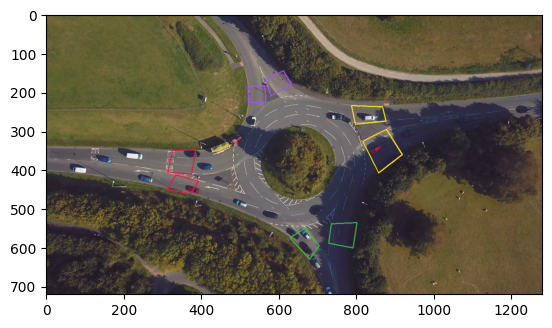

In [37]:
zones_in = initiate_polygon_zones(
            ZONE_IN_POLYGONS, video_info.resolution_wh, Position.CENTER
        )
        # Specifying the Zone that the cars get out of
zones_out = initiate_polygon_zones(
            ZONE_OUT_POLYGONS, video_info.resolution_wh, Position.CENTER
        )
frame_generator = get_video_frames_generator(
            source_path="/kaggle/input/video-sources/Stinsford Spiral Roundabout aerial view.mp4"
        )
for frame in tqdm(frame_generator, total=video_info.total_frames):
    annotated_frame = frame
    for i, (zone_in, zone_out) in enumerate(zip(zones_in, zones_out)):
        annotated_frame = draw_polygon(
                annotated_frame, zone_in.polygon, COLORS.colors[i]
            )
        annotated_frame = draw_polygon(
                annotated_frame, zone_out.polygon, COLORS.colors[i]
            )
    break
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

In [38]:
#cv2.imwrite('saved_frame.png', cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

In [39]:
class DetectionsManager:
    def __init__(self) -> None:
        self.tracker_id_to_zone_id: Dict[int, int] = {}
        self.counts: Dict[int, Dict[int, Set[int]]] = {}

    def update(
        self,
        detections_all: Detections,
        detections_in_zones: List[Detections],
        detections_out_zones: List[Detections],
    ) -> Detections:
        for zone_in_id, detections_in_zone in enumerate(detections_in_zones):
            for tracker_id in detections_in_zone.tracker_id:
                self.tracker_id_to_zone_id.setdefault(tracker_id, zone_in_id)

        for zone_out_id, detections_out_zone in enumerate(detections_out_zones):
            for tracker_id in detections_out_zone.tracker_id:
                if tracker_id in self.tracker_id_to_zone_id:
                    zone_in_id = self.tracker_id_to_zone_id[tracker_id]
                    self.counts.setdefault(zone_out_id, {})
                    self.counts[zone_out_id].setdefault(zone_in_id, set())
                    self.counts[zone_out_id][zone_in_id].add(tracker_id)

        detections_all.class_id = np.vectorize(
            lambda x: self.tracker_id_to_zone_id.get(x, -1)
        )(detections_all.tracker_id)
        return detections_all[detections_all.class_id != -1]

class VideoProcessor:
    def __init__(
        self,
        source_weights_path: str,
        source_video_path: str,
        target_video_path: str = None,
        confidence_threshold: float = 0.3,
        iou_threshold: float = 0.7,
    ) -> None:
        self.conf_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.source_video_path = source_video_path
        self.target_video_path = target_video_path
        # Reading the pretrained YOLO model
        self.model = YOLO(source_weights_path)
        # Initializing the ByteTrack Class
        self.tracker = ByteTrack()
        # Getting information about the video such as (example number of frames)
        self.video_info = VideoInfo.from_video_path(source_video_path)
        # Specifying the Zone that the cars go into
        self.zones_in = initiate_polygon_zones(
            ZONE_IN_POLYGONS, self.video_info.resolution_wh, Position.CENTER
        )
        # Specifying the Zone that the cars get out of
        self.zones_out = initiate_polygon_zones(
            ZONE_OUT_POLYGONS, self.video_info.resolution_wh, Position.CENTER
        )
        # Creating a instance of BoxAnnotator Class
        self.box_annotator = BoxAnnotator(color=COLORS)
        # Creating a instance of TraceAnnotator Class
        self.trace_annotator = TraceAnnotator(
            color=COLORS, position=Position.CENTER, trace_length=100, thickness=2
        )
        # Creating a instance of DetectionManager Class
        self.detections_manager = DetectionsManager()

    def process_video(self):
        frame_generator = get_video_frames_generator(
            source_path=self.source_video_path
        )

        if self.target_video_path:
            with VideoSink(self.target_video_path, self.video_info) as sink:
                for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                    annotated_frame = self.process_frame(frame)
                    sink.write_frame(annotated_frame)
        else:
            for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                annotated_frame = self.process_frame(frame)
                cv2.imshow("Processed Video", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
            cv2.destroyAllWindows()

    def annotate_frame(
        self, frame: np.ndarray, detections: Detections
    ) -> np.ndarray:
        annotated_frame = frame.copy()
        for i, (zone_in, zone_out) in enumerate(zip(self.zones_in, self.zones_out)):
            annotated_frame = draw_polygon(
                annotated_frame, zone_in.polygon, COLORS.colors[i]
            )
            annotated_frame = draw_polygon(
                annotated_frame, zone_out.polygon, COLORS.colors[i]
            )

        labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]
        annotated_frame = self.trace_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.box_annotator.annotate(
            annotated_frame, detections, labels
        )

        for zone_out_id, zone_out in enumerate(self.zones_out):
            zone_center = get_polygon_center(polygon=zone_out.polygon)
            if zone_out_id in self.detections_manager.counts:
                counts = self.detections_manager.counts[zone_out_id]
                for i, zone_in_id in enumerate(counts):
                    count = len(self.detections_manager.counts[zone_out_id][zone_in_id])
                    text_anchor = Point(x=zone_center.x, y=zone_center.y + 40 * i)
                    annotated_frame = draw_text(
                        scene=annotated_frame,
                        text=str(count),
                        text_anchor=text_anchor,
                        background_color= COLORS.colors[zone_in_id],
                    )

        return annotated_frame

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        results = self.model(
            frame, verbose=False, conf=self.conf_threshold, iou=self.iou_threshold
        )[0]
        detections = Detections.from_ultralytics(results)
        detections.class_id = np.zeros(len(detections))
        detections = self.tracker.update_with_detections(detections)

        detections_in_zones = []
        detections_out_zones = []

        for i, (zone_in, zone_out) in enumerate(zip(self.zones_in, self.zones_out)):
            detections_in_zone = detections[zone_in.trigger(detections=detections)]
            detections_in_zones.append(detections_in_zone)
            detections_out_zone = detections[zone_out.trigger(detections=detections)]
            detections_out_zones.append(detections_out_zone)

        detections = self.detections_manager.update(
            detections, detections_in_zones, detections_out_zones
        )
        return self.annotate_frame(frame, detections)



processor = VideoProcessor(
    source_weights_path="/kaggle/input/sorces/traffic_analysis.pt",
    source_video_path="/kaggle/input/video-sources/Stinsford Spiral Roundabout aerial view.mp4",
    target_video_path="/kaggle/working/result_Stinsford Spiral Roundabout aerial view.mp4",
)
processor.process_video()

100%|██████████| 16361/16361 [11:41<00:00, 23.33it/s]
